# Site Monitoring with the Harmonized Landsat Sentinel-2 dataset

This notebook demonstrates how to conduct a crop monitoring analysis using a cloud-masked time series of satellite imagery of Harmonized Landsat Sentinel-2 (HLS) dataset. 

Conda environment for this notebook

```yml
name: geo_py312
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.12
  - gdal=3.10
  - pip
  - dask
  - flox
  - folium
  - geopandas
  - httpx
  - imageio
  - ipykernel
  - jupyter
  - jupyterlab
  - matplotlib
  - nbformat
  - numpy
  - pandas
  - planetary-computer
  - pyproj
  - pystac
  - pystac-client
  - rasterio
  - rioxarray
  - rtree
  - shapely
  - xarray
  - zarr
  - pip:
      - odc-stac>=0.4
```

In [1]:
import re
from datetime import datetime

from IPython.display import Image, display
from io import BytesIO

import httpx
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pyproj
import pystac
import pystac_client
import planetary_computer
import rioxarray
import scipy.signal as signal
import xarray as xr
import xrspatial.multispectral as ms
from rasterio.features import rasterize
from shapely.geometry import box, shape
from shapely.ops import transform
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm, trange

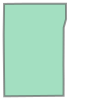

In [2]:
# get county boundary for any point
epsg = 4326
lat, lon = 41.79, -88.94

county_request = httpx.get(
    "https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2023/State_County/MapServer/13/query",
    params={
        "geometry": {"x": lon, "y": lat},
        "geometryType": "esriGeometryPoint",
        "inSR": {"wkid": epsg},
        "spatialRel": "esriSpatialRelIntersects",
        "f": "geoJSON",
    }
)

fc = county_request.json()
aoi = shape(fc["features"][0]["geometry"])
aoi

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
HLS2_L30 = "hls2-l30"
HLS2_S30 = "hls2-s30"

collections = {
    collection_id: catalog.get_collection(collection_id)
    for collection_id in [HLS2_L30, HLS2_S30]
}

for collection_id, collection in collections.items():
    for key, asset in collection.extra_fields["item_assets"].items():
        if collection_id == HLS2_L30 and key == "B05":
            asset["eo:bands"][0]["common_name"] = "nir08"
        if collection_id == HLS2_S30 and key == "B8A":
            asset["eo:bands"][0]["common_name"] = "nir08"

In [5]:
hls_odc_stac_config = {
    collection_id: {
        "assets": {
            "*": {
                "nodata": -9999,
                "data_type": "int16",
            },
            "Fmask": {
                "nodata": 0,
                "data_type": "uint8",
            },
        },
        "aliases": {
            asset["eo:bands"][0]["common_name"]: key
            for key, asset in collection.extra_fields["item_assets"].items()
            if asset["eo:bands"][0].get("common_name")
        }
    }
    for collection_id, collection in collections.items()
}

In [6]:
datetime_range = [datetime(2024, 4, 1), datetime(2024, 11, 1)]
bbox = aoi.bounds
search = catalog.search(
    collections=[HLS2_L30, HLS2_S30],
    datetime=datetime_range,
    bbox=bbox,
)

hls_items = search.item_collection()
print(len(hls_items))

99


In [7]:
def group_by_sensor_and_date(
    item: pystac.Item,
    parsed: odc.stac.ParsedItem,
    idx: int,
) -> str:
    id_split = item.id.split(".")
    sensor = id_split[1]
    day = id_split[3][:7]

    return f"{sensor}_{day}"

In [17]:
# load the xarray Dataset in a CONUS-wide projected CRS
target_crs = "epsg:5070"
transformer = pyproj.Transformer.from_crs(
    crs_from=epsg,
    crs_to=target_crs,
    always_xy=True,
)

aoi_5070 = transform(transformer.transform, aoi)
bbox_5070 = aoi_5070.bounds

# these are the ones that we are going to use
bands = ["red", "green", "blue", "nir08", "Fmask"]

stack = odc.stac.load(
    hls_items,
    stac_cfg=hls_odc_stac_config,
    bands=bands,
    crs=target_crs,
    resolution=30,
    chunks={},
    groupby=group_by_sensor_and_date,
    x=(bbox_5070[0], bbox_5070[2]),
    y=(bbox_5070[1], bbox_5070[3]),
).sortby("time")

stack

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 2027, x: 1073, time: 99)
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 792B 2024-04-02T17:01:54.392140 ... 20...
Data variables:
    red          (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    green        (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    blue         (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    nir08        (time, y, x) int16 431MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    Fmask        (time, y, x) uint8 215MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>

In [9]:
# geographic mask for the original AOI
aoi_mask = rasterize(
    [(aoi_5070, 1)],
    out_shape=(stack.rio.height, stack.rio.width),
    transform=stack.rio.transform(),
    fill=0,
    all_touched=True,
    dtype=np.uint8
).astype(bool)

In [12]:
# code for rendering gifs from xarray data
import imageio.v2 as imageio
import io
from IPython.display import Image


# Function to plot a single frame and return as a BytesIO object
def plot_frame(data, time_idx, title, figsize=(10, 10), units_label=None, progress: bool = False, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(data.isel(time=time_idx), **kwargs)
    ax.axis("off")

    # Adjust layout to reduce whitespace
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.25)
    
    # Main title at the top
    fig.suptitle(title, fontsize=12, y=0.92)

    # reference time coordinate at the bottom left
    fig.text(0.1, 0.05, f"datetime: {data.time.values[time_idx]}", ha="left", fontsize=10)
    
    # Horizontal colorbar below the image
    if kwargs.get("cmap"):
        cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.03])
        cbar = plt.colorbar(im, cax=cbar_ax, orientation="horizontal")
        cbar.set_label(units_label, fontsize=10, labelpad=3)
        cbar.ax.xaxis.set_label_position("top")
    
    # Progress bar at the very bottom
    if progress:
        total_frames = data.sizes["time"]
        progress = (time_idx + 1) / total_frames
        progress_bar = plt.Rectangle((0.1, 0.02), progress * 0.8, 0.02, transform=fig.transFigure, color="blue")
        fig.patches.append(progress_bar)
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
    buf.seek(0)
    return buf

def render_gif(
    data: xr.DataArray,
    title: str,
    fps: int = 4,
    units_label: str | None = None,
    figsize=(10, 10),
    progress: bool = True,
    **kwargs,
):
    # Create frames in memory
    frames = []
    for t in trange(data.sizes["time"]):
        frame = plot_frame(data, t, title, figsize=figsize, units_label=units_label, progress=progress, **kwargs)
        frames.append(imageio.imread(frame))
    
    gif_bytes = io.BytesIO()
    imageio.mimsave(gif_bytes, frames, format="GIF", fps=fps, loop=0)
    gif_bytes.seek(0)
    
    return Image(data=gif_bytes.read())

In [13]:
# massage the xarray.Dataset into an RGB array that is ready to plot
rgb_max = 1000

rgb_stack = (
    (
        stack.to_dataarray(dim="band").sel(band=["red", "green", "blue"])
        .where(aoi_mask)
        .where(stack["red"] != -9999.0)
        .transpose("y", "x", "band", "time")
        .sel(time=slice("2024-07-01", "2024-07-31"))
    ) / rgb_max
).clip(0, 1)

Image(
    render_gif(
        rgb_stack,
        "HLS: July 2024 in DeKalb County, IL",
        vmin=0,
        vmax=1000,
        figsize=(10, 10),
        progress=True,
    )
)

  0%|          | 0/19 [00:00<?, ?it/s]

ValueError: all input arrays must have the same shape

In [15]:
# check for datetimes where the proportion of valid pixels is acceptable
hls_mask_bitfields = [1, 2, 3]  # cloud shadow, adjacent to cloud shadow, cloud
hls_bitmask = 0
for field in hls_mask_bitfields:
    hls_bitmask |= 1 << field

print(hls_bitmask)

14


In [16]:
fmask = stack["Fmask"].astype("uint16")
valid_mask = ((fmask & hls_bitmask) == 0).where(aoi_mask)

Image(
    render_gif(
        valid_mask.sel(time=slice("2024-07-01", "2024-07-31")),
        "HLS valid mask: July 2024 in DeKalb County, IL",
        vmin=0,
        vmax=1,
        cmap="Greens",
    )
)

  0%|          | 0/19 [00:00<?, ?it/s]

ValueError: all input arrays must have the same shape

In [16]:
valid_proportions = valid_mask.mean(dim=["x", "y"], skipna=True)

valid_threshold = 0.5
valid_datetimes = (valid_proportions >= valid_threshold)

In [17]:
cloud_free_stack = (
    stack
    .where(valid_mask == 1)
    .sel(time=valid_datetimes)
    .compute()
)

cloud_free_stack

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 53, y: 2027, x: 1073)
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 424B 2024-04-12T17:01:56.375150 ... 20...
Data variables:
    red          (time, y, x) float32 461MB nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 461MB nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float32 461MB nan nan nan nan ... nan nan nan nan
    nir08        (time, y, x) float32 461MB nan nan nan nan ... nan nan nan nan
    swir16       (time, y, x) float32 461MB nan nan nan nan ... nan nan nan nan
    swir22       (time, y, x) float32 461MB nan nan nan nan ... nan nan nan nan
    Fmask        (time, y, x) float32 461MB nan nan nan nan ... nan nan nan nan

  0%|          | 0/53 [00:00<?, ?it/s]

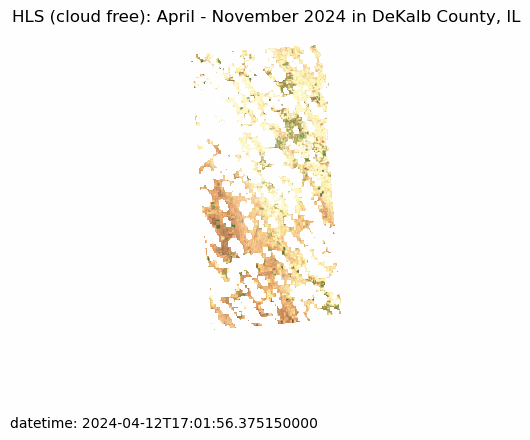

In [18]:
Image(
    render_gif(
        (
            (
                cloud_free_stack.to_dataarray(dim="band")
                .sel(band=["red", "green", "blue"])
                .transpose("y", "x", "band", "time")
            ) / rgb_max
        ).clip(0, 1),
        "HLS (cloud free): April - November 2024 in DeKalb County, IL",
        vmin=0,
        vmax=1000,
    )
)

In [19]:
# get land cover from Impact Obseratory
landcover_collection_id = "io-lulc-annual-v02"

landcover_search = catalog.search(
    collections=landcover_collection_id,
    bbox=bbox,
)

landcover_items = landcover_search.item_collection()

landcover_stack = odc.stac.load(
    landcover_items,
    crs=target_crs,
    resolution=30,
    dtype="uint8",
    chunks={},
    x=(bbox_5070[0], bbox_5070[2]),
    y=(bbox_5070[1], bbox_5070[3]),
)["data"].squeeze()

landcover_stack

<xarray.DataArray 'data' (time: 7, y: 2027, x: 1073)> Size: 15MB
dask.array<data, shape=(7, 2027, 1073), dtype=uint8, chunksize=(1, 2027, 1073), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 56B 2017-01-01 2018-01-01 ... 2023-01-01
Attributes:
    nodata:   0

In [20]:
baseline_landcover = landcover_stack.isel(time=-1).drop_vars("time")
baseline_landcover

<xarray.DataArray 'data' (y: 2027, x: 1073)> Size: 2MB
dask.array<getitem, shape=(2027, 1073), dtype=uint8, chunksize=(2027, 1073), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
Attributes:
    nodata:   0

In [21]:
IO_LANDCOVER_CLASSIFICATION_VALUES = {
    0: "no data",
    1: "water",
    2: "trees",
    4: "flooded vegetation",
    5: "crops",
    7: "built area",
    8: "bare ground",
    9: "snow/ice",
    10: "clouds",
    11: "rangeland",
}

landcover_values = np.array(list(IO_LANDCOVER_CLASSIFICATION_VALUES.keys()))
landcover_labels = np.array(list(IO_LANDCOVER_CLASSIFICATION_VALUES.values()))

label_mapping = xr.DataArray(
    landcover_values,
    dims=["landcover_class"],
    coords={"landcover_class": landcover_labels}
)

# add landcover values as coordinates to the imagery stack
cloud_free_with_landcover = (
    cloud_free_stack
    .assign_coords(
        coords={"landcover_class": (("y", "x"), baseline_landcover.data)}
    )
)


  0%|          | 0/53 [00:00<?, ?it/s]

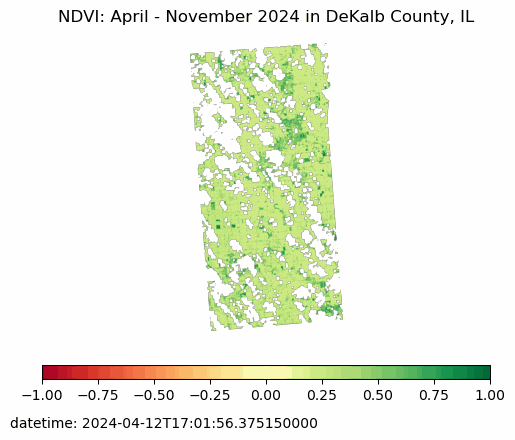

In [22]:
ndvi = (
    (cloud_free_with_landcover["nir08"] - cloud_free_with_landcover["red"]) / 
    (cloud_free_with_landcover["nir08"] + cloud_free_with_landcover["red"])
)

ndvi = ndvi.where(np.isfinite(ndvi))

Image(
    render_gif(
        (
            (
                ndvi
                .ffill(dim="time")
                .transpose("y", "x", "time")
            )
        ),
        "NDVI: April - November 2024 in DeKalb County, IL",
        vmin=-1,
        vmax=1,
        cmap="RdYlGn",
    )
)

  0%|          | 0/53 [00:00<?, ?it/s]

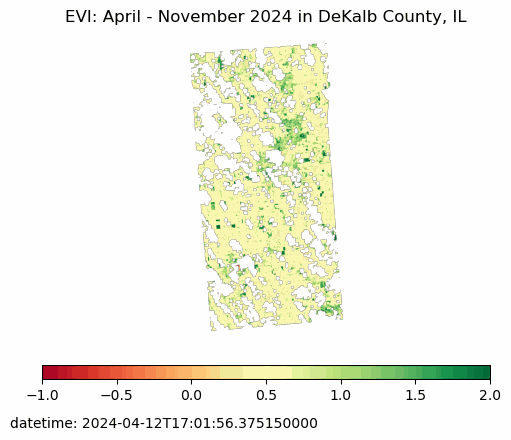

In [23]:
# EVI = G × [(NIR - RED) / (NIR + C1 × RED - C2 × BLUE + L)]
# G = Gain factor (typically 2.5)
# L = Canopy background adjustment (typically 1)
# C1, C2 = Coefficients for aerosol resistance (typically 6 and 7.5)

evi = 2.5 * (
    (cloud_free_with_landcover["nir08"] - cloud_free_with_landcover["red"]) / 
    (cloud_free_with_landcover["nir08"] + 6 * cloud_free_with_landcover["red"] - 7.5 * cloud_free_with_landcover["blue"] + 1)
)

evi = evi.where(np.isfinite(evi))

Image(
    render_gif(
        (
            (
                evi
                .ffill(dim="time")
                .transpose("y", "x", "time")
            )
        ),
        "EVI: April - November 2024 in DeKalb County, IL",
        vmin=-1,
        vmax=2,
        cmap="RdYlGn",
    )
)

In [45]:
ndvi

<xarray.DataArray (time: 53, y: 2027, x: 1073)> Size: 461MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(53, 2027, 1073), dtype=float32)
Coordinates:
  * y                (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06
  * x                (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref      int32 4B 5070
  * time             (time) datetime64[ns] 424B 2024-04-12T17:01:56.375150 .....
    landcover_class  (y, x) uint8 2MB dask.array<chunksize=(2027, 1073), meta=np.ndarray>

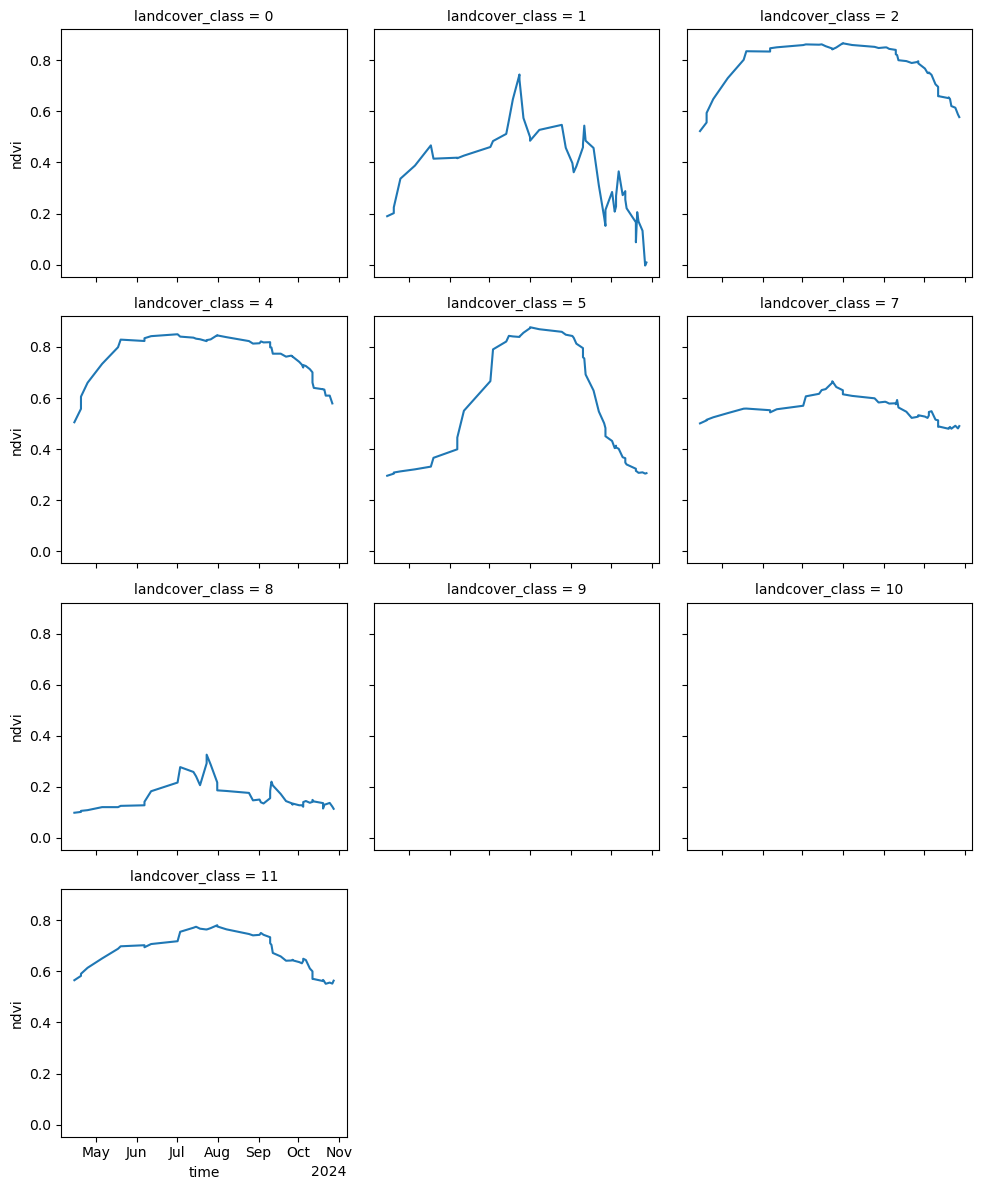

In [54]:
avg_ndvi_trend = (
    ndvi
    .groupby(
        landcover_class=xr.groupers.UniqueGrouper(labels=landcover_values)
    )
    .mean(dim=["x", "y"], skipna=True)
    .chunk({"time": -1})
    .interpolate_na(dim="time", method="linear", limit=3)
    .rolling(time=3, center=True)
    .mean()
    .assign_coords(
        coords={"landcover_name": ("landcover_class", landcover_labels)}
    )
    .rename("ndvi")
    .drop_vars("spatial_ref")
    .compute()
)

xr.plot.line(
    avg_ndvi_trend,
    x="time",
    col="landcover_class",
    col_wrap=3,
)

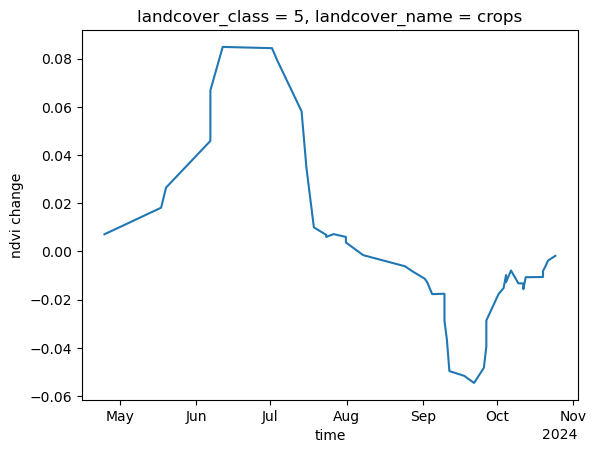

In [70]:
avg_ndvi_delta = (
    avg_ndvi_trend
    .diff(dim="time", n=1)
    .rolling(time=5, center=True)
    .mean()
    .rename("ndvi change")
)

xr.plot.line(
    avg_ndvi_delta.sel(landcover_class=5),
    x="time",
)

In [76]:
pixel_baseline_ndvi_delta = avg_ndvi_delta.sel(landcover_class=baseline_landcover)

pixel_ndvi_delta = ndvi.diff(dim="time", n=1)

deviation_over_time = pixel_ndvi_delta - pixel_baseline_ndvi_delta
deviation_over_time

<xarray.DataArray (time: 52, y: 2027, x: 1073)> Size: 452MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(52, 2027, 1073), dtype=float32)
Coordinates:
  * y                (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06
  * x                (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref      int32 4B 5070
  * time             (time) datetime64[ns] 416B 2024-04-14T16:52:02.107540 .....
    landcover_class  (y, x) uint8 2MB 5 5 5 5 5 5 5 5 5 5 ... 5 5 7 7 5 5 5 5 5
    landcover_name   (y, x) <U18 157MB 'crops' 'crops' ... 'crops' 'crops'

  0%|          | 0/52 [00:00<?, ?it/s]

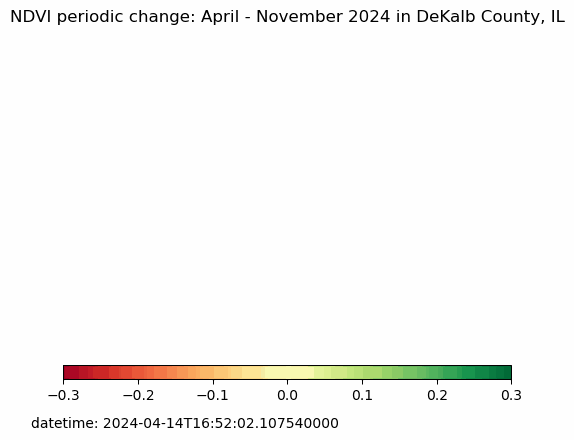

In [77]:
Image(
    render_gif(
        (
            (
                deviation_over_time
                .transpose("y", "x", "time")
            )
        ),
        "NDVI periodic change: April - November 2024 in DeKalb County, IL",
        vmin=-0.3,
        vmax=0.3,
        cmap="RdYlGn",
    )
)

In [90]:
threshold = -0.2

crop_anomalies = (
    (deviation_over_time < threshold) &
    (pixel_baseline_ndvi_delta > 0) &
    (baseline_landcover == 5)
    .compute()
)
crop_anomalies

<xarray.DataArray (time: 52, y: 2027, x: 1073)> Size: 113MB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]],
      shape=(52, 2027, 1073))
Coordinates:
  * y                (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06
  * x                (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref      int32 4B 5070
  * time             (time) datetime64[ns] 416B 2024-04-14T16:52:02.107540 .....
    landcover_class  (y, x) uint8 2MB 5 5 5 5 5 5 5 5 5 5 ... 5 5 7 7 5 5 5 5 5
    landcover_name   (y, x) <U18 157MB 'crops' 'crops' ... 'crops' 'crops'

  0%|          | 0/52 [00:00<?, ?it/s]

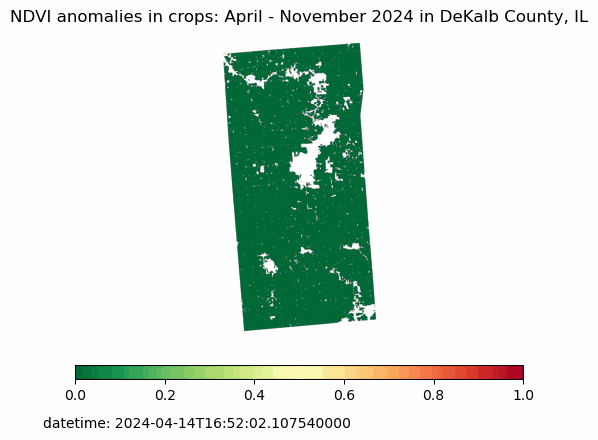

In [92]:
Image(
    render_gif(
        (
            (
                (1 * crop_anomalies)
                .where(baseline_landcover == 5)
                .where(aoi_mask == 1)
                .transpose("y", "x", "time")
            )
        ),
        "NDVI anomalies in crops: April - November 2024 in DeKalb County, IL",
        vmin=0,
        vmax=1,
        cmap="RdYlGn_r",
    )
)

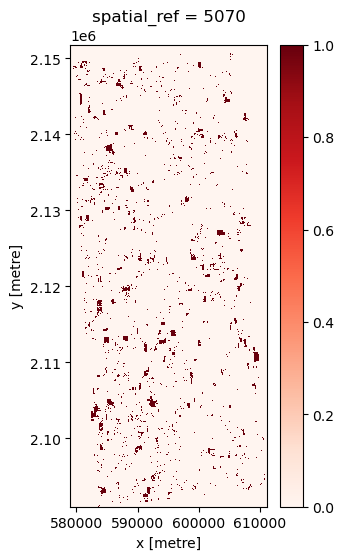

In [102]:
crop_anomaly_mask = crop_anomalies.any(dim="time").compute()

crop_anomaly_mask.plot.imshow(
    aspect=stack.rio.width / stack.rio.height,
    size=6,
    robust=True,
    vmin=0,
    vmax=1,
    cmap="Reds"
)

In [103]:
crop_anomaly_mask.rio.set_crs(target_crs)
crop_anomaly_mask_4326 = crop_anomaly_mask.astype(int).rio.reproject("epsg:4326")


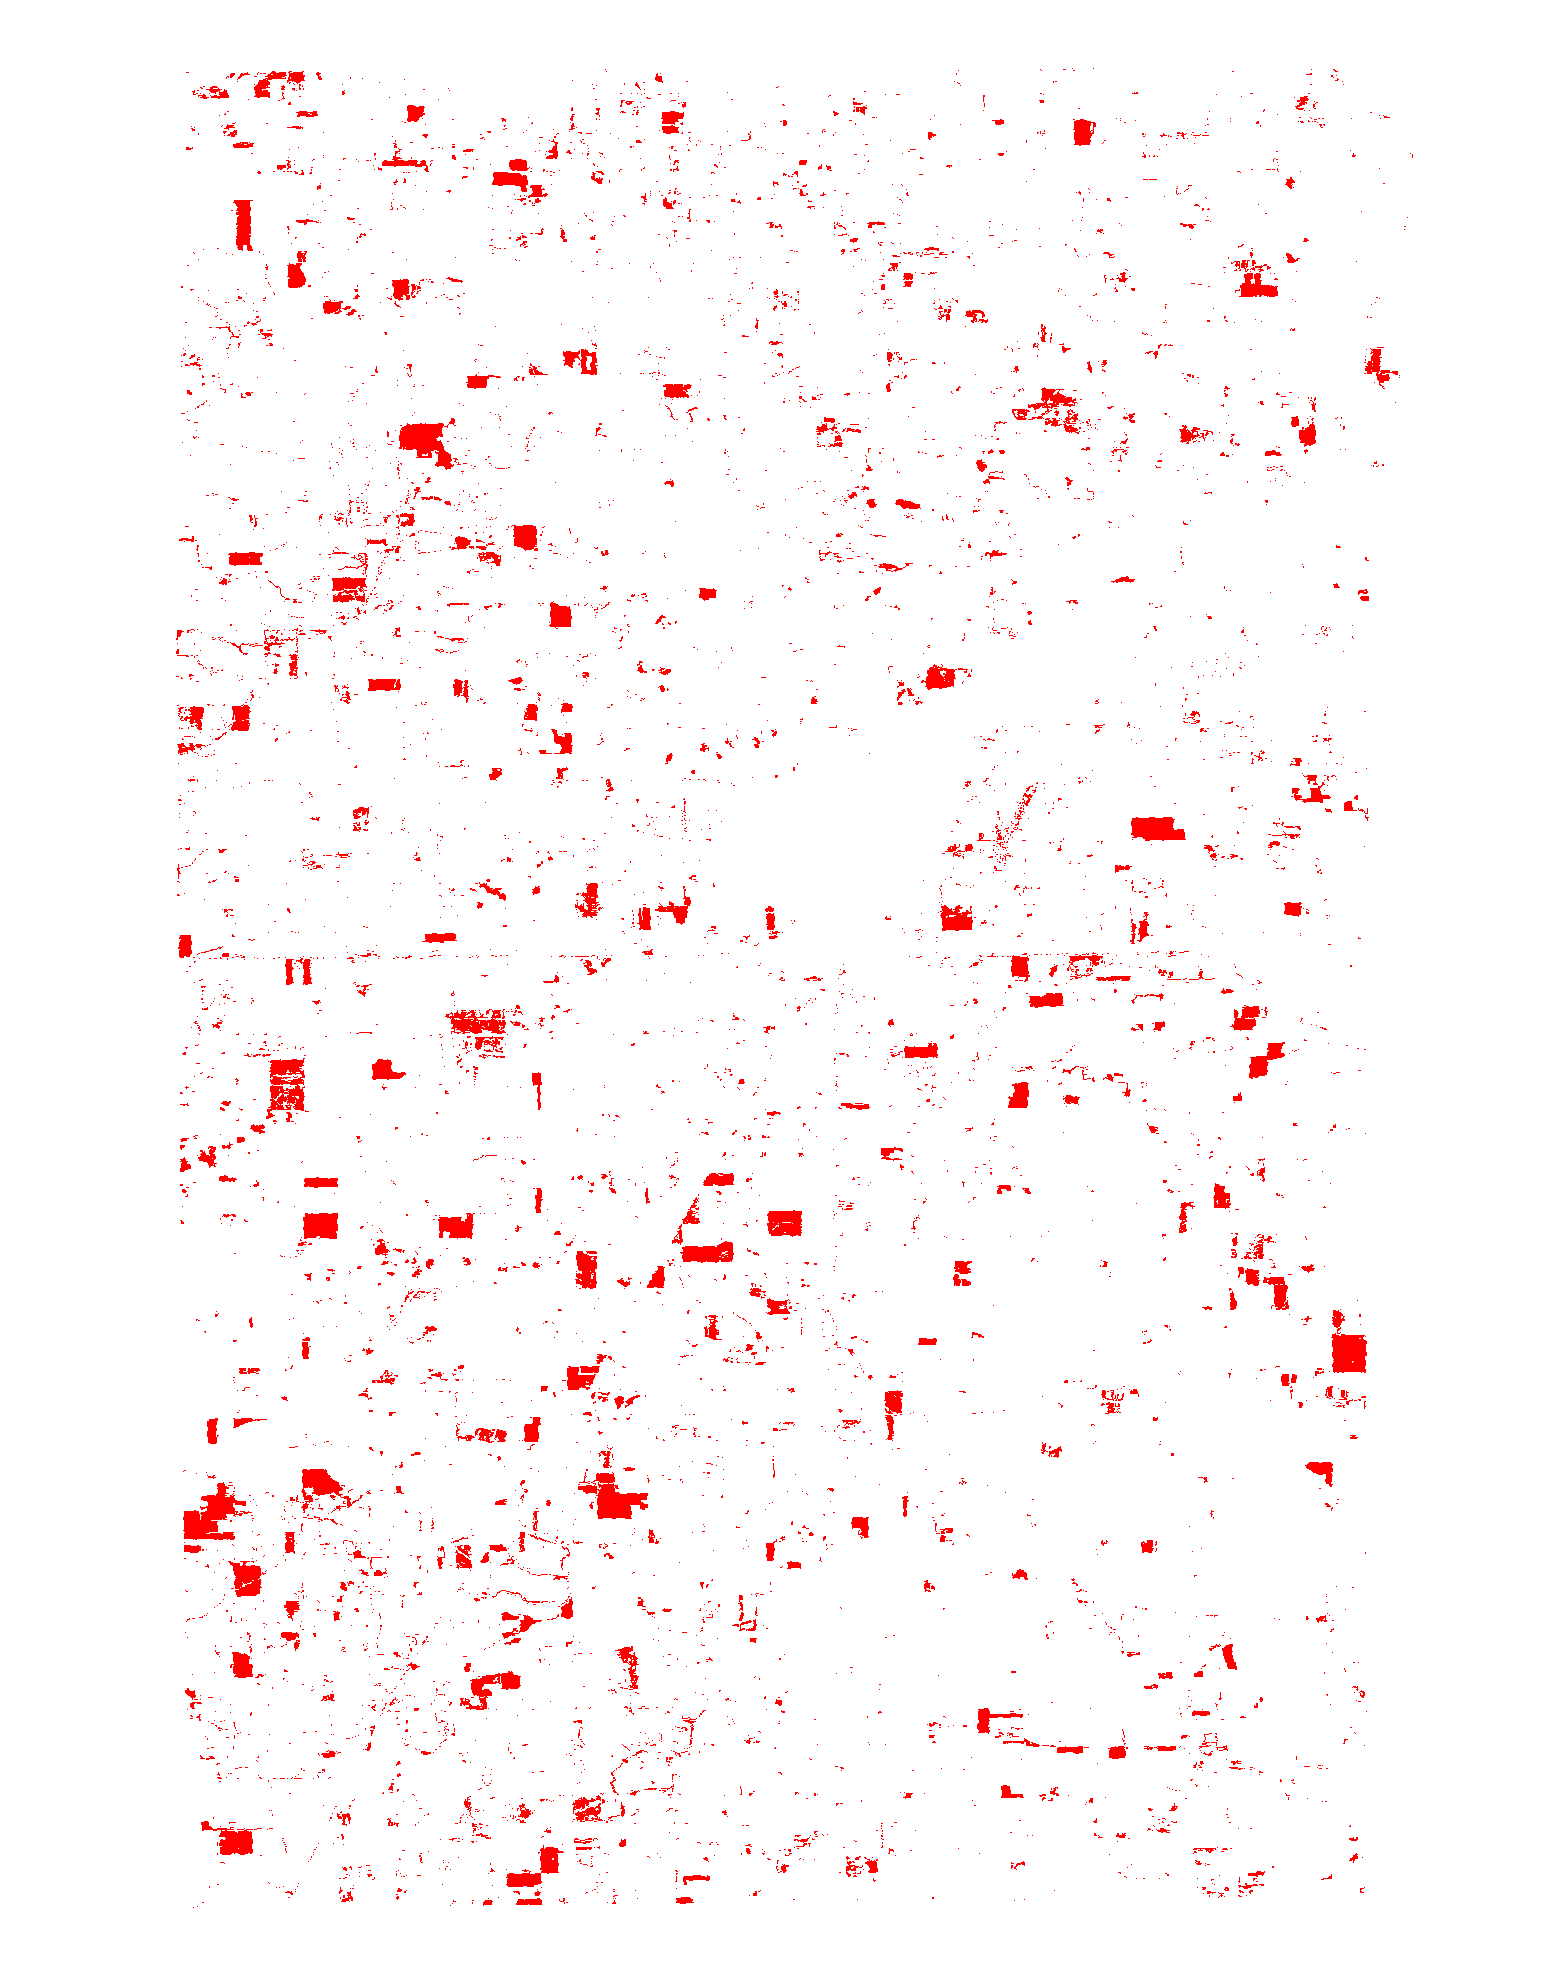

In [108]:
import folium
from rasterio.warp import transform_bounds


m = folium.Map([lat, lon], zoom_start=10)

minx, miny, maxx, maxy = crop_anomaly_mask_4326.rio.bounds()

folium.raster_layers.ImageOverlay(
    name="ndvi anomalies",
    image=crop_anomaly_mask_4326.data,
    bounds=[[miny, minx], [maxy, maxx]],
    colormap=lambda x: (x, 0, 0, x),
).add_to(m)

folium.features.GeoJson(
    data=aoi,
    name="DeKalb County, IL",
).add_to(m)

folium.LayerControl().add_to(m)

m